# Classifying embeddings - dashboard

In [1]:
import os
from glob import glob
from typing import Any, Optional, cast

import ipywidgets as widgets
import pandas as pd
from IPython.display import Javascript, display

from sentence_topology.classification.analysis import ClassifierAnalysisResults

In [2]:
def update_cells_below() -> None:
    display(
        Javascript(
            "IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()"
            " + 1, IPython.notebook.ncells());"
        )
    )


def display_dropdown(
    options: list[str],
    description: str,
    value: Optional[str] = None,
) -> widgets.Dropdown:
    dropdown = widgets.Dropdown(
        options=options,
        value=value,
        description=description,
        disabled=False,
    )

    def update_selected_context(change: dict[str, Any]) -> None:
        if change["name"] == "value" and change["old"] != change["new"]:
            update_cells_below()

    dropdown.observe(update_selected_context)

    display(dropdown)

    return dropdown

In [3]:
RESULTS_DIR = "../results/cls_gs"
contexts = glob(os.path.join(RESULTS_DIR, "*"))
contexts = list(map(os.path.basename, contexts))

context_dropdown = display_dropdown(
    options=contexts,
    value=contexts[0],
    description="Context:",
)

<IPython.core.display.Javascript object>

Dropdown(description='Context:', options=('no_context', 'diff'), value='no_context')

In [4]:
context = cast(str, context_dropdown.value)
cls_results_root = os.path.join(RESULTS_DIR, context)

scores = cast(
    pd.DataFrame, pd.read_pickle(os.path.join(cls_results_root, "scores.pkl"))
)
scores["Best"] = scores.max(axis=1)
scores.sort_values(by="Best", ascending=False)

,DecisionTreeClassifier,MLPClassifier,RandomForestClassifier,SVC,KNeighborsClassifier,Best
paraphrase-multilingual-MiniLM-L12-v2_supervised_1.tsv,0.313786,0.342620,0.361570,0.357182,0.329116,0.361570
paraphrase-multilingual-MiniLM-L12-v2_supervised_0.tsv,0.275981,0.354014,0.346202,0.353680,0.322096,0.354014
paraphrase-multilingual-MiniLM-L12-v2_supervised_2.tsv,0.276283,0.307845,0.319101,0.334921,0.292982,0.334921
paraphrase-multilingual-MiniLM-L12-v2_supervised_3.tsv,0.264285,0.304014,0.324963,0.305512,0.284259,0.324963
tfidf_all.tsv,0.234598,0.302103,0.314739,0.278573,0.173740,0.314739
bow_limited.tsv,0.233616,0.278796,0.305906,0.250094,0.104588,0.305906
tfidf_limited.tsv,0.227729,0.273870,0.303335,0.242076,0.078409,0.303335
bow_all.tsv,0.226457,0.303230,0.301769,0.260571,0.045512,0.303230
paraphrase-multilingual-MiniLM-L12-v2_supervised_4.tsv,0.212158,0.300369,0.295830,0.291052,0.280847,0.300369
paraphrase-multilingual-MiniLM-L12-v2.tsv,0.115238,0.251868,0.191485,0.243372,0.141197,0.251868


In [5]:
params = pd.read_pickle(os.path.join(cls_results_root, "params.pkl"))
params.sort_index()

,DecisionTreeClassifier,MLPClassifier,RandomForestClassifier,SVC,KNeighborsClassifier
bow_all.tsv,"{'max_depth': 32, 'max_leaf_nodes': 50, 'min_s...","{'activation': 'relu', 'hidden_layer_sizes': (...","{'max_depth': 25, 'min_samples_split': 10, 'n_...","{'svc__gamma': 'auto', 'svc__kernel': 'linear'}","{'knn__n_neighbors': 3, 'knn__weights': 'dista..."
bow_limited.tsv,"{'max_depth': 32, 'max_leaf_nodes': 50, 'min_s...","{'activation': 'relu', 'hidden_layer_sizes': (...","{'max_depth': 25, 'min_samples_split': 5, 'n_e...","{'svc__gamma': 'auto', 'svc__kernel': 'linear'}","{'knn__n_neighbors': 3, 'knn__weights': 'unifo..."
doc2vec-cs-vecsize-512-train-1M-sents.tsv,"{'max_depth': 32, 'max_leaf_nodes': 70, 'min_s...","{'activation': 'logistic', 'hidden_layer_sizes...","{'max_depth': None, 'min_samples_split': 10, '...","{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 3, 'knn__weights': 'dista..."
doc2vec_vsize_10.tsv,"{'max_depth': 32, 'max_leaf_nodes': 70, 'min_s...","{'activation': 'relu', 'hidden_layer_sizes': (...","{'max_depth': None, 'min_samples_split': 10, '...","{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 10, 'knn__weights': 'dist..."
doc2vec_vsize_100.tsv,"{'max_depth': 32, 'max_leaf_nodes': 50, 'min_s...","{'activation': 'logistic', 'hidden_layer_sizes...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 3, 'knn__weights': 'dista..."
doc2vec_vsize_2.tsv,"{'max_depth': 32, 'max_leaf_nodes': 70, 'min_s...","{'activation': 'relu', 'hidden_layer_sizes': (...","{'max_depth': 5, 'min_samples_split': 5, 'n_es...","{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 3, 'knn__weights': 'dista..."
doc2vec_vsize_256.tsv,"{'max_depth': 18, 'max_leaf_nodes': 70, 'min_s...","{'activation': 'logistic', 'hidden_layer_sizes...","{'max_depth': 25, 'min_samples_split': 5, 'n_e...","{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 5, 'knn__weights': 'dista..."
doc2vec_vsize_3.tsv,"{'max_depth': 32, 'max_leaf_nodes': 70, 'min_s...","{'activation': 'relu', 'hidden_layer_sizes': (...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'svc__gamma': 'scale', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 5, 'knn__weights': 'dista..."
mixup_all_doc2vec-cs-vecsize-512-train-1M-sents.tsv,"{'max_depth': 18, 'max_leaf_nodes': 70, 'min_s...","{'activation': 'relu', 'hidden_layer_sizes': (...","{'max_depth': 5, 'min_samples_split': 5, 'n_es...","{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 3, 'knn__weights': 'dista..."
mixup_all_doc2vec_vsize_10.tsv,"{'max_depth': 18, 'max_leaf_nodes': 70, 'min_s...","{'activation': 'relu', 'hidden_layer_sizes': (...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}","{'knn__n_neighbors': 5, 'knn__weights': 'dista..."


In [6]:
best_cls_root = os.path.join(cls_results_root, "best_classifier_analysis")
print(best_cls_root)

../results/cls_gs/no_context/best_classifier_analysis


In [7]:
embeddings = glob(os.path.join(best_cls_root, "*.pkl"))
print(embeddings)

['../results/cls_gs/no_context/best_classifier_analysis/mixup_all_doc2vec_vsize_3.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_by_seed_paraphrase-multilingual-MiniLM-L12-v2.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_all_doc2vec-cs-vecsize-512-train-1M-sents.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_by_seed_doc2vec_vsize_100.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_by_seed_doc2vec_vsize_256.pkl', '../results/cls_gs/no_context/best_classifier_analysis/tfidf_all.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_all_doc2vec_vsize_10.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_by_seed_doc2vec_vsize_10.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_by_seed_doc2vec_vsize_3.pkl', '../results/cls_gs/no_context/best_classifier_analysis/mixup_all_paraphrase-multilingual-MiniLM-L12-v2_supervised_3.pkl', '../results/cls_gs/no_context/best_class

In [8]:
embeddings = [os.path.basename(path) for path in embeddings]
embeddings.sort()

embedd_dropdown = display_dropdown(
    embeddings, value=embeddings[0], description="Embedding:"
)

Dropdown(description='Embedding:', options=('bow_all.pkl', 'bow_limited.pkl', 'doc2vec-cs-vecsize-512-train-1M…

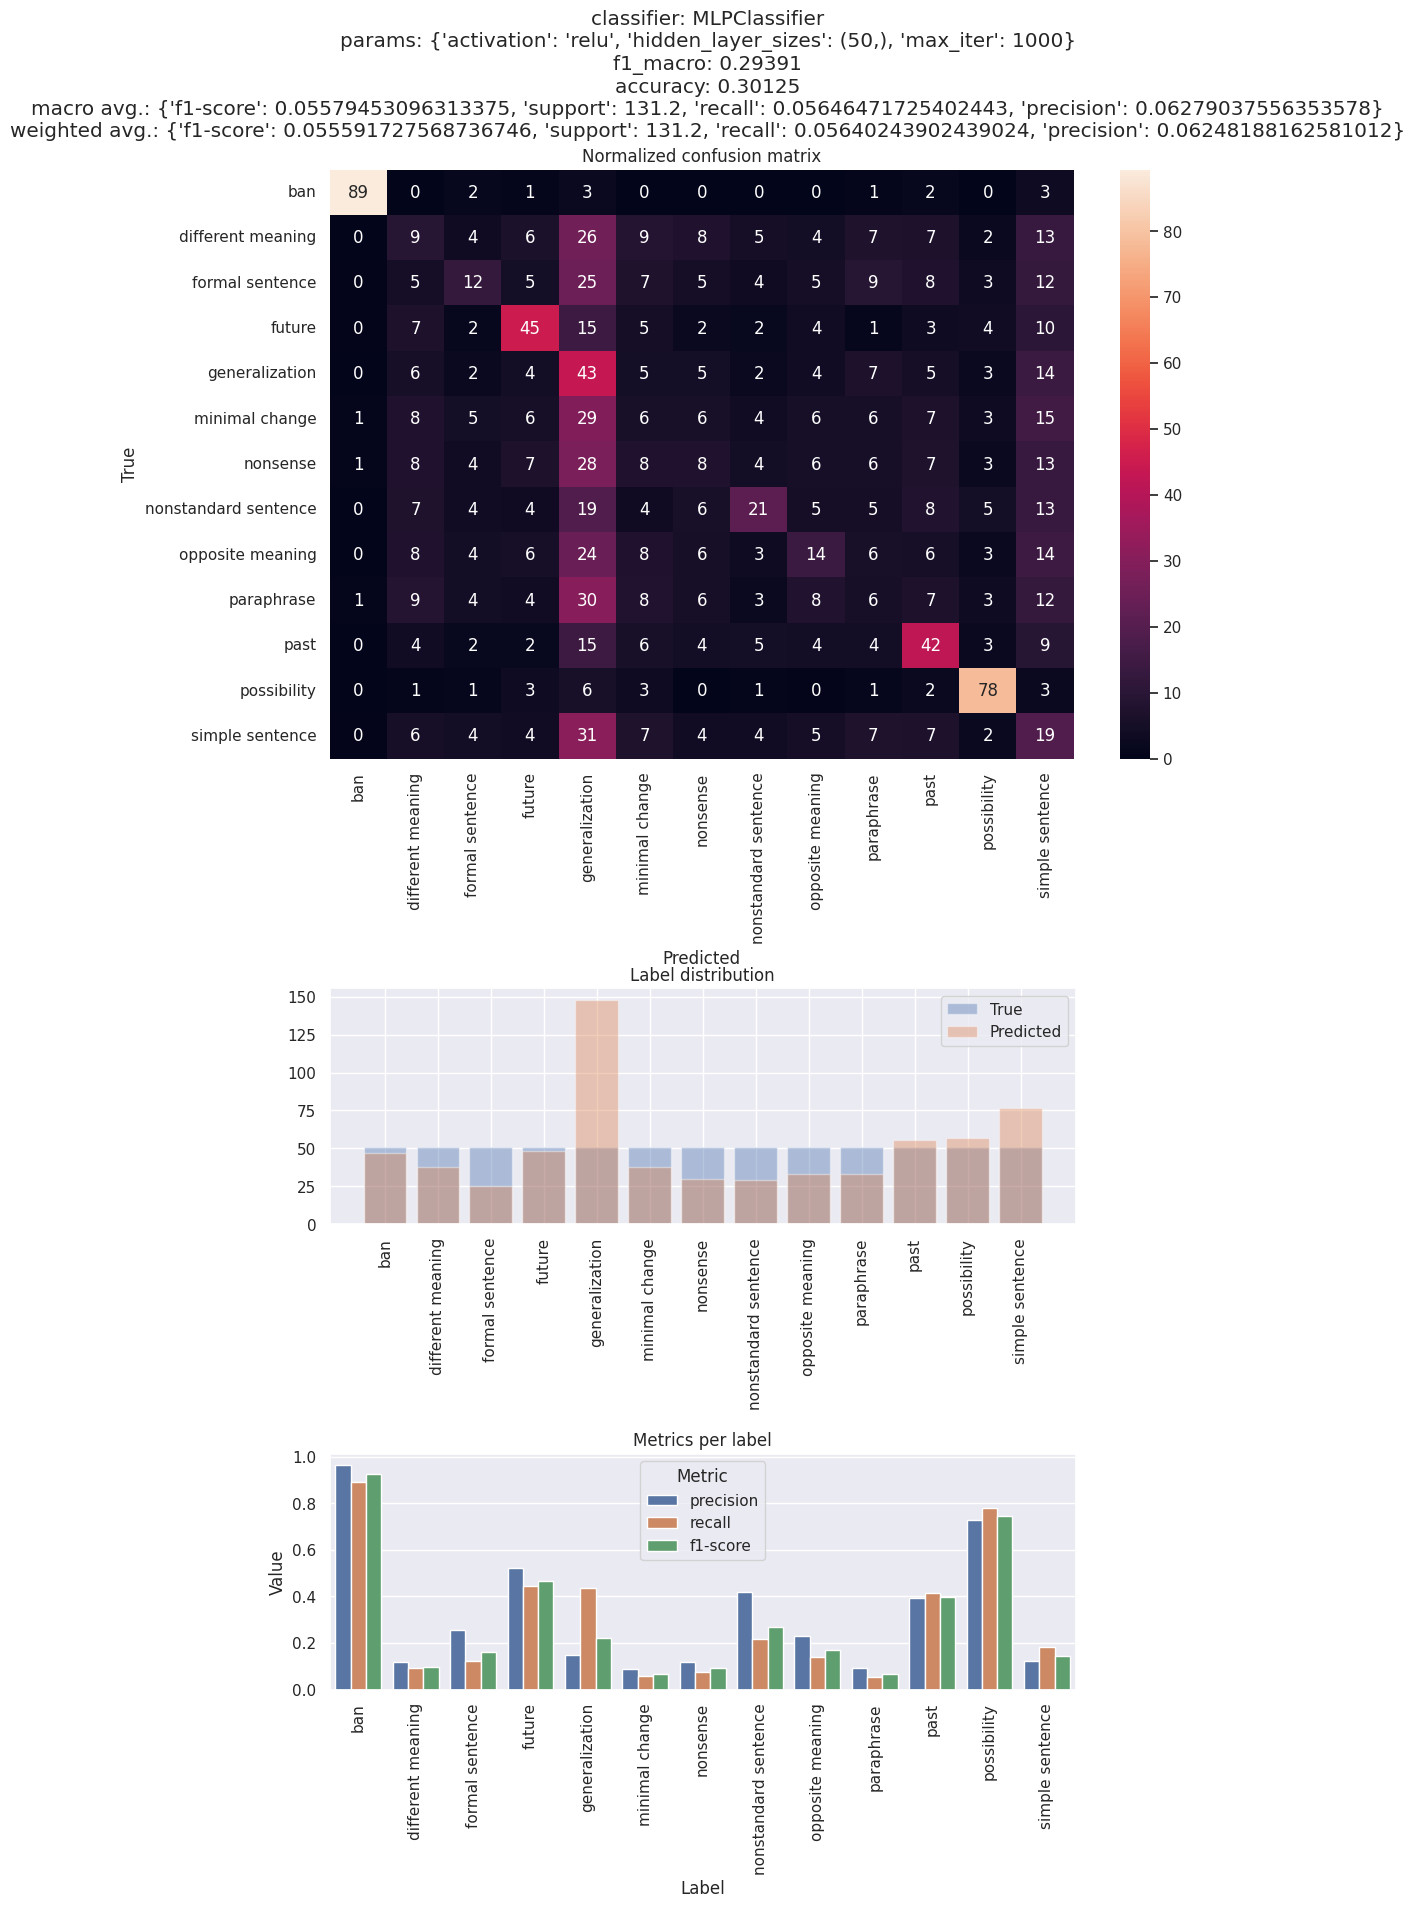

In [9]:

embedding_name = cast(str, embedd_dropdown.value)

cls_results = ClassifierAnalysisResults.load(
    os.path.join(best_cls_root, embedding_name)
)

cls_results.visualize()
print()